# 3G Data Plan Prices in Lebanon

In the following I will analyze different 3G data plans provided in Lebanon.

Prices at different points in time where collected from the provider [touch](https://touch.com.lb/).

Another mobile provider in Lebanon exist, but it provides the same prices since both touch and [alfa](https://www.alfa.com.lb/) are "state-owned"(?) and sleeping in the same bed.

As we say: "طيزان بفرد لباس" / "two ass cheeks in the same pants".

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import math

import statsmodels.api as sm

from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

## The Data

Data collected are in the following files: 1 -> 5 from older to newer, 5 being the recent pricing plans.

In [19]:
touch_files = ["lb-touch-1.csv", "lb-touch-2.csv",
                "lb-touch-3.csv", "lb-touch-4.csv",
                "lb-touch-5.csv"]

The following plot exhibits the data:

- On the $x$ axis we have the plan, i.e. the quota in GB
- On the $y$ axis we have the price in USD.

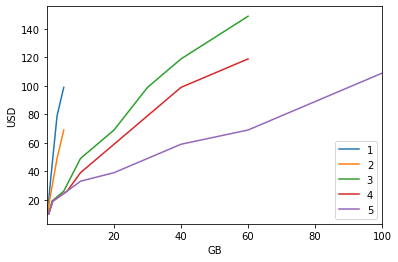

In [20]:
fig, ax = plt.subplots()

for idx, f in enumerate(touch_files):
    df = pd.read_csv(f)
    df.plot(ax=ax, kind="line", x="quota", y="price", label=str(idx + 1))

ax.set_xlabel("GB")
ax.set_ylabel("USD")

fig.show()

## Price vs Quota

It's fairly trivial to see that prices increase linearly.

I'm going to prove it doing a linear regression on the datasets, just because I have excess in computational power.

In [21]:
def price_vs_quota_ols_model(dataset):
    df = pd.read_csv(dataset)

    model_X = df["quota"]
    model_y = df["price"]

    model_X = sm.add_constant(model_X)
    model = sm.OLS(model_y, model_X).fit()

    return model

R<sup>2</sup> is high indeed all the datasets. Here's an example

In [22]:
print(price_vs_quota_ols_model(touch_files[4]).summary())

OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     306.8
Date:                Mon, 30 Mar 2020   Prob (F-statistic):           4.87e-07
Time:                        23:09:02   Log-Likelihood:                -25.813
No. Observations:                   9   AIC:                             55.63
Df Residuals:                       7   BIC:                             56.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.7726      2.234      8.405      0.000      13.491      24.054
q

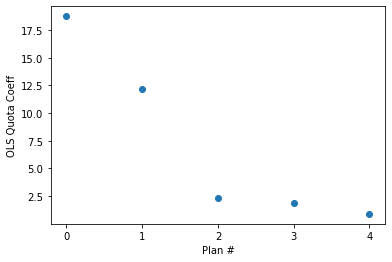

In [23]:

x = range(len(touch_files))
y = []

for f in touch_files:
    model = price_vs_quota_ols_model(f)
    y.append(model.params.quota)

fig, ax = plt.subplots()

plt.scatter(x, y)

ax.set_xlabel("Plan #")
ax.set_ylabel("OLS Quota Coeff")
xint = range(min(x), math.ceil(max(x))+1)
plt.xticks(xint)

fig.show()


But *how good is it for the consumer*?

It surely looks like the difference in plan prices is becoming less and less agressive every time they adjust the pricings, but how much are we really paying for a GB?

## Price Per GB

The following graph shows how much 1 GB of data costs in USD

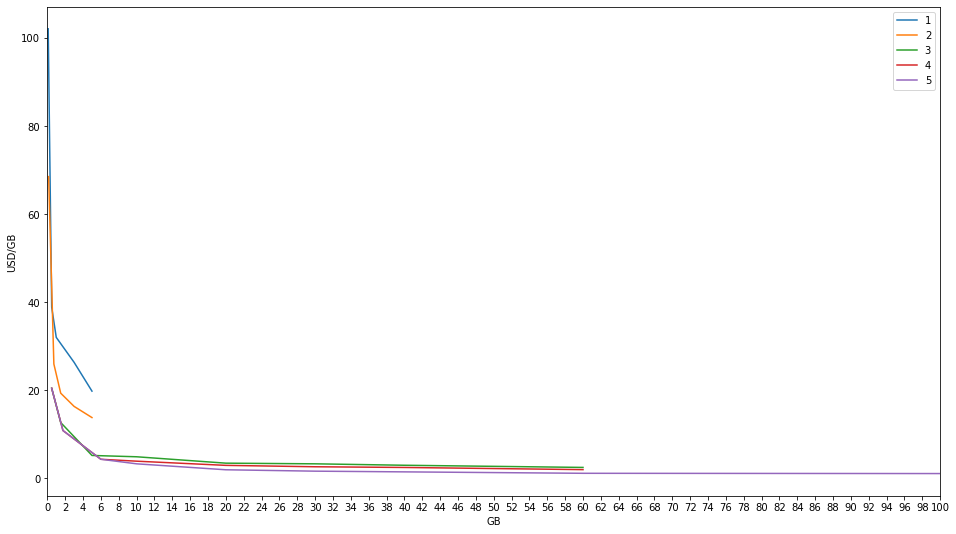

In [24]:
fig, ax = plt.subplots(figsize=(16,9))

for idx, f in enumerate(touch_files):
    df = pd.read_csv(f)
    df["per_dollar"] = df["price"] / df["quota"]
    df.plot(ax=ax, loglog=False, kind="line", x="quota", y="per_dollar", label=str(idx + 1))

ax.set_xlabel("GB")
ax.set_ylabel("USD/GB")
xint = range(0, 101,2)
plt.xticks(xint)

fig.show()

I don't know about you, but multiple things are clear:

1. The only significant decrease in pricing happened once. TODO: get the exact dates.
1. 2 clusters of pricings exists
   1. In the first cluster `(0, 1)`, a shift in prices happened.
   1. In the second cluster `(2, 3, 4)`, no significant changes seem to happen. It's merely a marketing campaign. Or Lies. I prefer to use the term lies.

But to really understand what's happening, we need to plot the graph on a loglog scale, because obviously we have exponential pricing schemes going on.

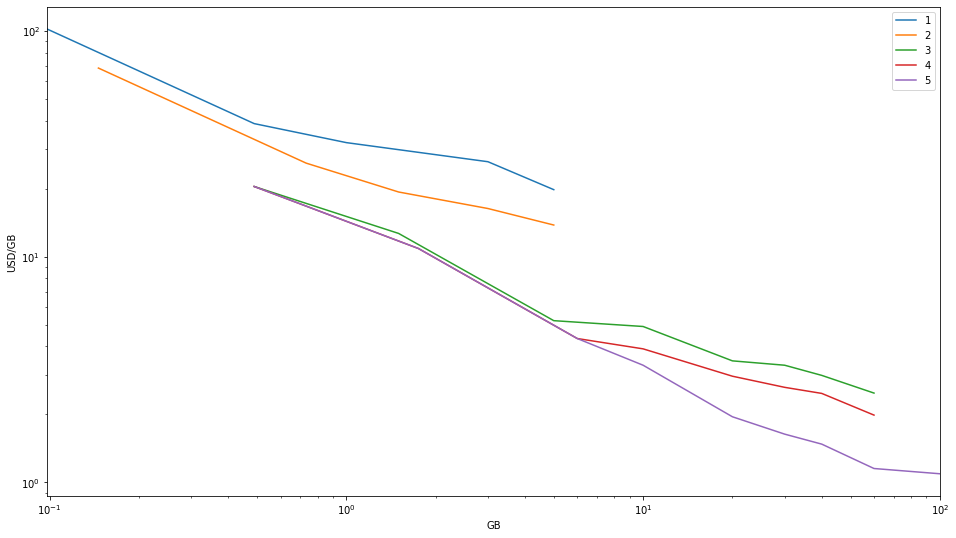

In [25]:
fig, ax = plt.subplots(figsize=(16,9))

for idx, f in enumerate(touch_files):
    df = pd.read_csv(f)
    df["per_dollar"] = df["price"] / df["quota"]
    df.plot(ax=ax, loglog=True, kind="line", x="quota", y="per_dollar", label=str(idx + 1))

ax.set_xlabel("GB")
ax.set_ylabel("USD/GB")
fig.show()

So maybe it was early to judge the price drops in the first cluster, but let's be honest for a moment, the new plot shows that:

1. Prices decrease exponentially the more you pay.
2. The last 3 changes in pricing are really changes on the higher end of the plans. Still an exponential scheme, but less aggressively so.

After doing a $log_{10}$ transform on the data, we can do a linear regression to see *how much exactly the prices drop*.

In [26]:
def price_per_GB_vs_quota_ols_model(dataset):
    df = pd.read_csv(dataset)

    model_X = np.log10(df["quota"])
    model_y = np.log10(df["price"] / df["quota"])

    model_X = sm.add_constant(model_X)
    model = sm.OLS(model_y, model_X).fit()

    return model

Here's the summary on the current pricing. All the datasets show very high R<sup>2</sup>.

In [27]:
print(price_per_GB_vs_quota_ols_model(touch_files[4]).summary())

OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     582.3
Date:                Mon, 30 Mar 2020   Prob (F-statistic):           5.34e-08
Time:                        23:09:05   Log-Likelihood:                 14.949
No. Observations:                   9   AIC:                            -25.90
Df Residuals:                       7   BIC:                            -25.50
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1217      0.032     35.109      0.000       1.046       1.197
q

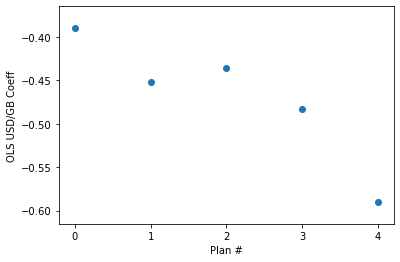

In [28]:
x = range(len(touch_files))
y = []

for f in touch_files:
    model = price_per_GB_vs_quota_ols_model(f)
    y.append(model.params.quota)

fig, ax = plt.subplots()

plt.scatter(x, y)

ax.set_xlabel("Plan #")
ax.set_ylabel("OLS USD/GB Coeff")
xint = range(min(x), math.ceil(max(x))+1)
plt.xticks(xint)

fig.show()

The pricing model is the following:

\begin{equation}
p =  10^{\beta} \times q^{\alpha}
\end{equation}

Where:
- $p$ is the price per GB
- $q$ is the quota
- $\alpha$ and $\beta$ are the USD/GB factor and the bias, respectively, from the OLS regression in log-log space.

For example, in the current pricing, $\alpha = -0.5901$ and $\beta = 1.1217$.

I started with the quest of finding the optimal price, but studying these equations for some time (and recalling human greed), 
I find the question a bit stupid:

The ideal scenario is when I pay $\$0$ and get $+\infty$ GB. Alas, reality is a bitch, where the optimal price to pay is always going to be the highest ever,
especially when a beautiful exponential is at hand.

Formally, to find the optimal price per GB, we take the derivative of $p$ w.r.t. $q$, and set it to $0$:

\begin{equation}
\frac{d}{dq} p = p' = 10^{\beta} \times \alpha \times q^{\alpha - 1}
\end{equation}

Intuitively, $p'$ represents the rate of change in $p$, the price per GB; $p' = -10$ means that the price per GB is decreasing by 10 folds.

$p'$ will reach $0$ on the limit when $x \to +\infty$. Which is practically never in our case: the more you pay, the better the gains are.

Plotting the derivative $p'$ is interesting though:

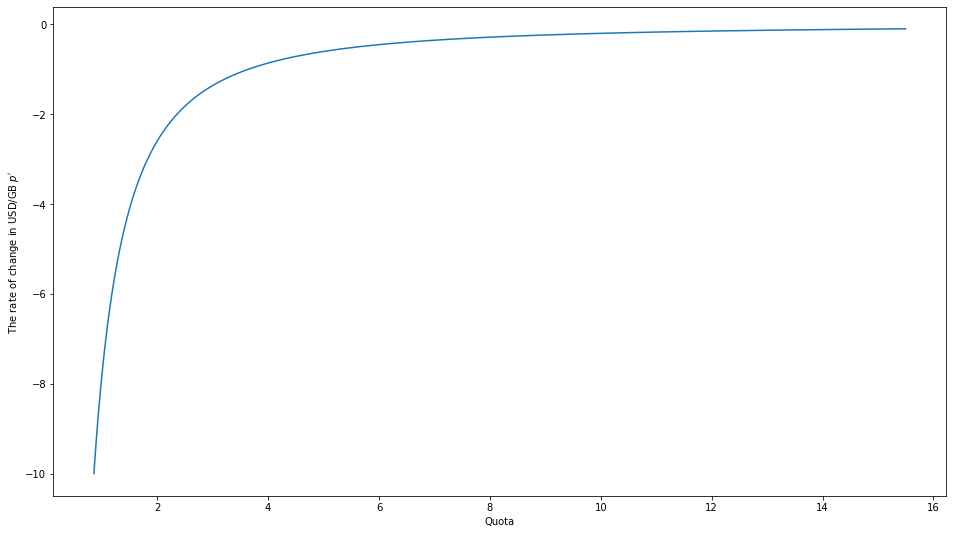

In [29]:
alpha = -0.5901
beta = 1.1217

theta = np.linspace(-10, -.1, 1000)

q = (theta * (1/(alpha * 10**(beta))))**(1/(alpha - 1))

p = (10**beta)*alpha*(q**(alpha - 1))

fig, ax = plt.subplots(figsize=(16,9))

plt.plot(q, theta)
ax.set_xlabel("Quota")
ax.set_ylabel(r"The rate of change in USD/GB $p'$")
fig.show()


The question is now *"how much do I like to get raped by the telecom company?*.

It seems to me that any plan that offers less than 6 GB of data is the on the very rapy end of the spectrum.

So if you can afford it, get any plan $\ge$ 6 GB.

## Now what?

The only conclusion I can come up with is that 3G data plans are super overpriced; Big news eh?
And the fact that the bundle cost per GB decreases exponentially makes the situation worst.

2 real price drops happened: 1 minor one between `0` and `1`, and one major between `1` and `2`.
The rest are lies. Enjoy the rape.